# Project 01: one protein against many ligands 

The purpose is to find interaction hotspots in a single target through the analysis of interactions found in a dataset of diverse small compounds.

This was used in the prototype pipeline to elucidate hotspots in the sars-cov-19 protease, and we will refine it here against other datasets.

The workflow itself consists of three steps:

1. Obtaining and sanitizing the data
2. Ingesting it in `plipify`
3. Generating publication-worthy figures

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import requests
r = requests.get(f"https://fragalysis.diamond.ac.uk/api/targets/?format=json")
r.raise_for_status()
targets = [t["title"] for t in r.json()["results"] if t["zip_archive"]]
print("Downloadable targets:", *targets)

Downloadable targets: NUDT7A ATAD BRD1A DCP2B FAM83BA MURD NUDT4A OXA10OTA PARP14A PHIPA PTP1B SMTGR ACVR1A ATAD2A CAMK1DA DCLRE1AA FALZA HAO1A MUREECA NUDT21A NUDT4 NUDT5A NUDT7A_CRUDE smTGRNEW STAG1A TBXTA VIM2 XX02KALRNA TNCA ALAS2A EPB41L3A mArh INPP5DA nsp13 Mac1 Mpro NSP15_B MUREECOLI PGN_RS02895PGA


In [3]:
from pathlib import Path

TARGET = "Mpro"  # other options, see above

HERE = Path(_dh[-1])
DATA = HERE / "data" / TARGET
OUT = HERE / "output" / TARGET
DATA.mkdir(exist_ok=True, parents=True)
OUT.mkdir(exist_ok=True, parents=True)

## Obtaining and sanitizing the data

We will be using data from [_Fragalysis_](), a XRC platform that generates structures for ligand collections against a given target. API endpoint is described [here](https://fragalysis.diamond.ac.uk/api/?format=api), but in short, it seems that you can download a full featured zip file using this URL: `https://fragalysis.diamond.ac.uk/media/targets/$TARGETNAME.zip`.

In [4]:
r = requests.get(f"https://fragalysis.diamond.ac.uk/api/targets/?format=json&title={TARGET}")
r.raise_for_status()
target = r.json()["results"][0]

if target["zip_archive"] is None:
    raise ValueError(f"Target {TARGET} is not downloadable")

,crystal_name,RealCrystalName,smiles,new_smiles,alternate_name,site_name,pdb_entry,ROMol
1,Mpro-x11271_0A,Mpro-x11271,COC=1C=C(Cl)C=C(CC(=O)NC=2C=NC=CC2C)C1,NaN,MAT-POS-c9973a83-1,Aminopyridine-like,NaN,
2,Mpro-x11041_0A,Mpro-x11041,CN(C(=O)CC=1C=CC=C(Cl)C1)C=2C=NC=CC2C,NaN,JAN-GHE-83b26c96-15,Aminopyridine-like,NaN,
3,Mpro-x1002_0A,Mpro-x1002,OC=1C=CC=CN1,NaN,AAR-POS-0daf6b7e-37,XChem Screen - xtal contact,5RF4,
4,Mpro-x10155_0A,Mpro-x10155,CC(N1CCN(Cc2cnc(Cc3ccccc3)s2)CC1)=O,CC(N1CCN(Cc2cnc(Cc3ccccc3)s2)CC1)=O,MED-COV-4280ac29-25,Chloroacetamide,NaN,
6,Mpro-x1101_1A,Mpro-x1101,CC(C)N(C)C=1N=CN=C2N(C)N=CC12,NaN,AAR-POS-0daf6b7e-40,XChem Screen - xtal contact,5RGR,
...,...,...,...,...,...,...,...,...
1175,Mpro-P0039_0B,Mpro-P0039,NC[C@]1(CCOC=2C=CC(Cl)=CC21)C(=O)NC=3C=NC=C4C=...,NC[C@]1(CCOC=2C=CC(Cl)=CC21)C(=O)NC=3C=NC=C4C=...,EDG-MED-971238d3-5,Isoquinoline,NaN,
1176,Mpro-x10535_0A,Mpro-x10535,Cl.ClC=1C=CC=C(C1)N2C(=O)NC(C2=O)C=3C=CC=NC3,ClC=1C=CC=C(C1)N2C(=O)NC(C2=O)C=3C=CC=NC3,JAN-GHE-83b26c96-18,Aminopyridine-like,NaN,
1177,Mpro-P0240_0A,Mpro-P0240,ClC=1C=CC=2CNCC(C(=O)NC=3C=NC=C4C=CC=CC34)C2C1,ClC=1C=CC=2CNCC(C(=O)NC=3C=NC=C4C=CC=CC34)C2C1,BEN-DND-f2e727cd-5,Isoquinoline,NaN,
1178,Mpro-x12716_0A,Mpro-x12716,Cl.Cl.NC[C@]1(CCOC=2C=CC(Cl)=CC21)C(=O)NC=3C=N...,NC[C@]1(CCOC=2C=CC(Cl)=CC21)C(=O)NC=3C=NC=C4C=...,EDG-MED-971238d3-5,Isoquinoline,NaN,

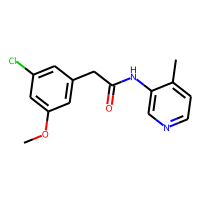
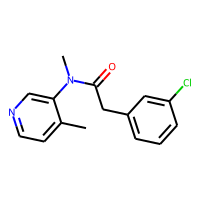
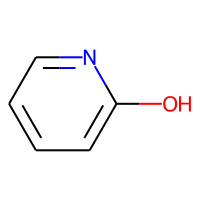
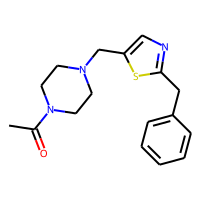
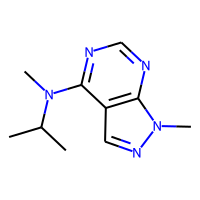
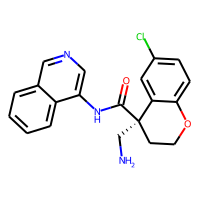
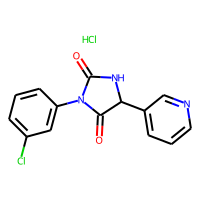
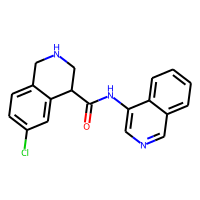
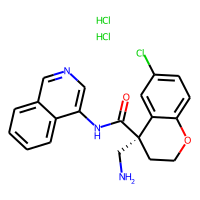
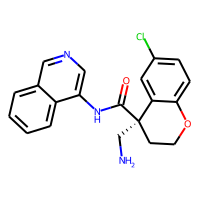

In [5]:
import pandas as pd
from rdkit.Chem.PandasTools import AddMoleculeColumnToFrame

metadata = requests.get(target["metadata"], stream=True)
metadata = pd.read_csv(metadata.raw, index_col=0)
AddMoleculeColumnToFrame(metadata, smilesCol="smiles")
metadata

Prealigned PDBs for each row can be found in `data/{target}/aligned/{crystal_name}/{crystal_name}_bound.pdb`:

In [6]:
from io import BytesIO
from zipfile import ZipFile

# If already downloaded, they should be here:
pdbs = list((DATA / "aligned").glob("**/*_bound.pdb"))

if not pdbs:
    archive =  requests.get(target["zip_archive"], stream=True)
    with BytesIO(archive.raw.data) as b, ZipFile(b) as z:
        z.extractall(DATA)
    # Reassign now
    pdbs = list((DATA / "aligned").glob("**/*_bound.pdb"))
    assert pdbs, "Couldn't find downloaded PDB structures!"

As the directory name suggests, these are prealigned:

In [7]:
import nglview as nv

view = nv.NGLWidget()
for pdb in pdbs[:10]:
    structure = nv.adaptor.FileStructure(str(pdb))
    comp = view.add_component(structure, default_representation=False)
    comp.add_cartoon()
    comp.add_ball_and_stick("LIG")
view.center("LIG")
view

NGLWidget()

In [8]:
view.render_image(factor=1, trim=True, transparent=True, antialias=True);

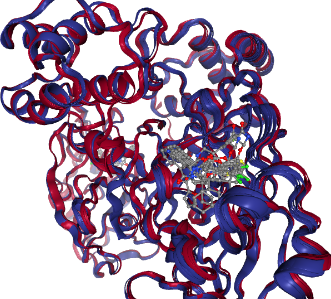

In [10]:
view._display_image()

Notice how binding sites are not always the same.

### tmp: Split files by chain

In [11]:
from Bio.PDB import *

print(pdbs[0])

for nr, filepath in enumerate(pdbs):
    pdb_id = str(pdbs[nr]).split('/')[-1][:-4]
    chain_id = str(pdbs[nr]).split('/')[-1].split('_')[1][-1]
    new_filename=str(pdbs[nr])[:-4]+'_chain'+str(chain_id)+'.pdb'
    
    ## Read the PDB file and extract the chain from structure[0]
    model = PDBParser(PERMISSIVE=1,QUIET=1).get_structure(pdb_id, filepath)[0]
    ### Save new file
    io = PDBIO()
    io.set_structure(model[chain_id])
    io.save(new_filename)
print (nr)

/home/andrea/devel/py/plipify/projects/01/data/Mpro/aligned/Mpro-P0008_0A/Mpro-P0008_0A_bound.pdb
492


Update the pdb list to pdb chain list

In [12]:
pdbs = list((DATA / "aligned").glob("**/*_bound_chain*.pdb"))
print(pdbs[0:3])

[PosixPath('/home/andrea/devel/py/plipify/projects/01/data/Mpro/aligned/Mpro-P0008_0A/Mpro-P0008_0A_bound_chainA.pdb'), PosixPath('/home/andrea/devel/py/plipify/projects/01/data/Mpro/aligned/Mpro-P0008_0B/Mpro-P0008_0B_bound_chainB.pdb'), PosixPath('/home/andrea/devel/py/plipify/projects/01/data/Mpro/aligned/Mpro-P0009_0A/Mpro-P0009_0A_bound_chainA.pdb')]


Check structures

In [13]:
import nglview as nv

view = nv.NGLWidget()
for pdb in pdbs[:10]:
    structure = nv.adaptor.FileStructure(str(pdb))
    comp = view.add_component(structure, default_representation=False)
    comp.add_cartoon()
    comp.add_ball_and_stick("LIG")
view.center("LIG")
view

NGLWidget()

## Ingesting it in `plipify` 

TBD.

In [14]:
from plipify.core import Structure
from plipify.fingerprints import InteractionFingerprint
from tqdm.auto import tqdm

In [15]:
structures = []
for path in tqdm(pdbs):
    structure = Structure.from_pdbfile(str(path), ligand_name="LIG")
    if len(structure.binding_sites) != 1:
        print(f"{path.relative_to(HERE)} contains {len(structure.binding_sites)} binding sites and we want exactly one.")
        continue
    structures.append(structure)

  0%|          | 0/493 [00:00<?, ?it/s]

data/Mpro/aligned/Mpro-x1101_0A/Mpro-x1101_0A_bound_chainA.pdb contains 2 binding sites and we want exactly one.
data/Mpro/aligned/Mpro-x1101_1A/Mpro-x1101_1A_bound_chainA.pdb contains 2 binding sites and we want exactly one.
data/Mpro/aligned/Mpro-x12025_0A/Mpro-x12025_0A_bound_chainA.pdb contains 2 binding sites and we want exactly one.
data/Mpro/aligned/Mpro-x12025_1A/Mpro-x12025_1A_bound_chainA.pdb contains 2 binding sites and we want exactly one.
data/Mpro/aligned/Mpro-z2zu2_0A/Mpro-z2zu2_0A_bound_chainA.pdb contains 0 binding sites and we want exactly one.
data/Mpro/aligned/Mpro-z2zu2_0B/Mpro-z2zu2_0B_bound_chainB.pdb contains 0 binding sites and we want exactly one.
data/Mpro/aligned/Mpro-z2zu2_1A/Mpro-z2zu2_1A_bound_chainA.pdb contains 0 binding sites and we want exactly one.
data/Mpro/aligned/Mpro-z4ylu_0A/Mpro-z4ylu_0A_bound_chainA.pdb contains 0 binding sites and we want exactly one.
data/Mpro/aligned/Mpro-z4ylu_0B/Mpro-z4ylu_0B_bound_chainB.pdb contains 0 binding sites and 

### Rudimentary filter to exclude artifacts (by sequence length deviation)

In [16]:
import pandas as pd
lengths = pd.DataFrame([((s.identifier), len(s.sequence())) for s in structures], columns=["identifier", "length"])
# Remove entries where the difference sequence length - median sequence length is greater than one standard deviation
print('Sequence length median and std: ',lengths.length.median(),lengths.length.std() )

Sequence length median and std:  304.0 1.3704707370361833


In [17]:
lengths = lengths[(lengths.length - lengths.length.median()).abs() < lengths.length.std()]
filtered_structures = [s for s in structures if s.identifier in set(lengths.identifier.tolist())]
print(len(pdbs), "->", len(structures), "->", len(filtered_structures), "=", len(pdbs) - len(filtered_structures), "structures filtered out")

structures = filtered_structures

493 -> 466 -> 395 = 98 structures filtered out


In [18]:
from importlib import reload
import plipify.fingerprints, plipify.core, plipify.visualization
reload(plipify.fingerprints)
reload(plipify.core)
reload(plipify.visualization)
from plipify.fingerprints import InteractionFingerprint

### tmp fix: it seemed like the problem only occured in the 'MPro-P...' structures, so expluding them for now.
To avoid error when generating interatcion fingerprints `ValueError: Length mismatch: Expected axis has 296 elements, new values have 305 element`

In [19]:
# count type of structures
structure_name_type_dict={'Mpro-P':0, 'Mpro-x':0, 'Mpro-z':0, 'other':0}
print(structure_name_type_dict.keys())
for s in structures:
    name_code = s.identifier[0:6]
    if name_code in structure_name_type_dict.keys():
        structure_name_type_dict[name_code]+=1
    else:
        structure_name_type_dict['other']+=1
print(structure_name_type_dict)

dict_keys(['Mpro-P', 'Mpro-x', 'Mpro-z', 'other'])
{'Mpro-P': 35, 'Mpro-x': 359, 'Mpro-z': 1, 'other': 0}


In [20]:
# exclude 35 Mpro-P structures
filtered_structures = [s for s in structures if not (s.identifier.startswith('Mpro-P'))]
print('remaining: ',len(filtered_structures), 'from:', len(structures))
structures = filtered_structures

remaining:  360 from: 395


In [21]:
# Review
fp = InteractionFingerprint().calculate_fingerprint(
        structures,
        labeled=True, 
        as_dataframe=True, 
        remove_non_interacting_residues=True,
        remove_empty_interaction_types=True,
        ensure_same_sequence=False
    )

if not fp.values.shape[0]:
    raise ValueError("Fingerprint is empty!")

In [22]:
fp.style.background_gradient(axis=None, cmap="YlGnBu")

,hydrophobic,hbond-don,hbond-acc,saltbridge,pistacking,pication,halogen
6,1,1,0,0,0,0,0
8,2,0,0,0,0,0,0
12,1,1,0,0,0,1,0
24,1,0,1,0,0,0,0
25,23,3,0,0,0,0,0
26,1,3,3,0,0,0,0
27,2,0,0,0,0,0,0
31,0,0,0,0,1,0,0
41,32,2,12,1,184,16,0
44,0,0,4,0,0,0,0


This fingerprint is too sparse, let's try to focus on the hotspots only (arbitrarily defined now as "residue with more than 10 total interactions, regardless the type")

In [23]:
fp_focused = fp[fp.sum(axis=1) > 10]

In [24]:
fp_focused.style.background_gradient(axis=None, cmap="YlGnBu")

,hydrophobic,hbond-don,hbond-acc,saltbridge,pistacking,pication,halogen
25,23,3,0,0,0,0,0
41,32,2,12,1,184,16,0
49,18,0,0,0,0,0,1
140,2,0,10,0,0,0,2
142,122,33,25,0,0,0,0
143,0,109,3,0,0,0,0
144,0,100,1,0,0,0,0
145,0,74,0,0,0,0,0
164,1,4,7,0,0,0,2
165,107,0,0,0,0,0,0


### Using nglview to color the side chains
Adapted from this [gist](https://gist.github.com/dominiquesydow/1aa19cc5583a31bfbd58bc8a066a7705) by Dominique Sydow: 

In [42]:
# add sum column
fp_focused['sum'] = fp_focused.sum(axis=1)

<ipython-input-42-7e6db4f77b69>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [43]:
fp_focused

,hydrophobic,hbond-don,hbond-acc,saltbridge,pistacking,pication,halogen,sum
25,23,3,0,0,0,0,0,52
41,32,2,12,1,184,16,0,494
49,18,0,0,0,0,0,1,38
140,2,0,10,0,0,0,2,28
142,122,33,25,0,0,0,0,360
143,0,109,3,0,0,0,0,224
144,0,100,1,0,0,0,0,202
145,0,74,0,0,0,0,0,148
164,1,4,7,0,0,0,2,28
165,107,0,0,0,0,0,0,214


In [44]:
# prepare color maps
max_n_interactions = fp_focused["sum"].max()
max_n_interactions

850

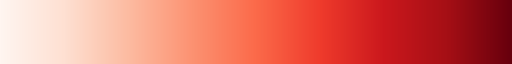

In [45]:
from matplotlib import cm, colors
cmap = cm.get_cmap("Reds", max_n_interactions)
cmap

In [46]:
# Get residue-color map
# NGLview needs color as hex code
fp_focused["color"] = fp_focused["sum"].apply(lambda x: colors.rgb2hex(cmap(x)))
# NGLview needs residue IDs as str
fp_focused["residue_id_str"] = fp_focused.index.astype(str)
fp_focused

<ipython-input-46-470244d9d4dc>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-46-470244d9d4dc>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,hydrophobic,hbond-don,hbond-acc,saltbridge,pistacking,pication,halogen,sum,color,residue_id_str
25,23,3,0,0,0,0,0,52,#ffebe1,25
41,32,2,12,1,184,16,0,494,#f34b36,41
49,18,0,0,0,0,0,1,38,#ffede5,49
140,2,0,10,0,0,0,2,28,#ffefe8,140
142,122,33,25,0,0,0,0,360,#fc8262,142
143,0,109,3,0,0,0,0,224,#fcb69c,143
144,0,100,1,0,0,0,0,202,#fcbfa6,144
145,0,74,0,0,0,0,0,148,#fdd1bf,145
164,1,4,7,0,0,0,2,28,#ffefe8,164
165,107,0,0,0,0,0,0,214,#fcbaa0,165


In [47]:
# convert to list as needed by nglview colorscheme
color_residue_map = fp_focused[["color", "residue_id_str"]].to_numpy().tolist()
color_residue_map

[['#ffebe1', '25'],
 ['#f34b36', '41'],
 ['#ffede5', '49'],
 ['#ffefe8', '140'],
 ['#fc8262', '142'],
 ['#fcb69c', '143'],
 ['#fcbfa6', '144'],
 ['#fdd1bf', '145'],
 ['#ffefe8', '164'],
 ['#fcbaa0', '165'],
 ['#67000d', '166'],
 ['#ffede5', '187'],
 ['#fcb397', '189']]

In [48]:
color_scheme = nv.color._ColorScheme(color_residue_map, label="#interactions")

In [49]:
view = nv.NGLWidget()
# randomly picket pdbs[94] because it is the first one from the final selected structures: Mpro-x0072_0A_bound_chainA
structure = nv.adaptor.FileStructure(str(pdbs[94]))
view.add_component(structure, default_representation=False)

view.add_representation(
    "cartoon",
    selection="protein",
    color=color_scheme,
)

# add selected side chains
residue_list = fp_focused["residue_id_str"].tolist()
view.add_representation(
    'licorice', 
    selection=f"protein and ({' '.join([str(x) for x in residue_list])})",
    color=color_scheme,
)

view.add_ball_and_stick("LIG")
view.center("LIG")
view

NGLWidget()

In [50]:
for i, pdb in enumerate(pdbs):
    if str(structures[0].identifier) in str(pdb):
        print (i)
print(pdbs[94], '----------',structures[0].identifier)

94
/home/andrea/devel/py/plipify/projects/01/data/Mpro/aligned/Mpro-x0072_0A/Mpro-x0072_0A_bound_chainA.pdb ---------- Mpro-x0072_0A_bound_chainA


In [51]:
from plipify.visualization import fingerprint_barplot, fingerprint_heatmap, fingerprint_table, fingerprint_nglview

In [52]:
# drop added columns again
fp_focused.drop(["color", "residue_id_str", "sum"], axis=1, inplace=True)

/home/andrea/.local/miniconda/envs/test/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [53]:
fingerprint_barplot(fp_focused)

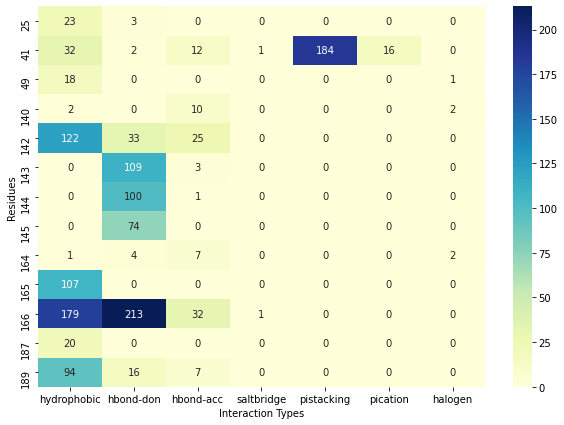

In [54]:
fingerprint_heatmap(fp_focused, cmap="YlGnBu");

In [55]:
fingerprint_table(fp_focused)

HTML(value='\n    <style>\n    \n    table.plipify-legend {\n        text-align: center;\n        color: #fff;…

In [56]:
view = fingerprint_nglview(fp_focused, structures[1])
view.center("LIG")
view

NGLWidget()

In [57]:
view.render_image(factor=1, trim=True, transparent=True, antialias=True);

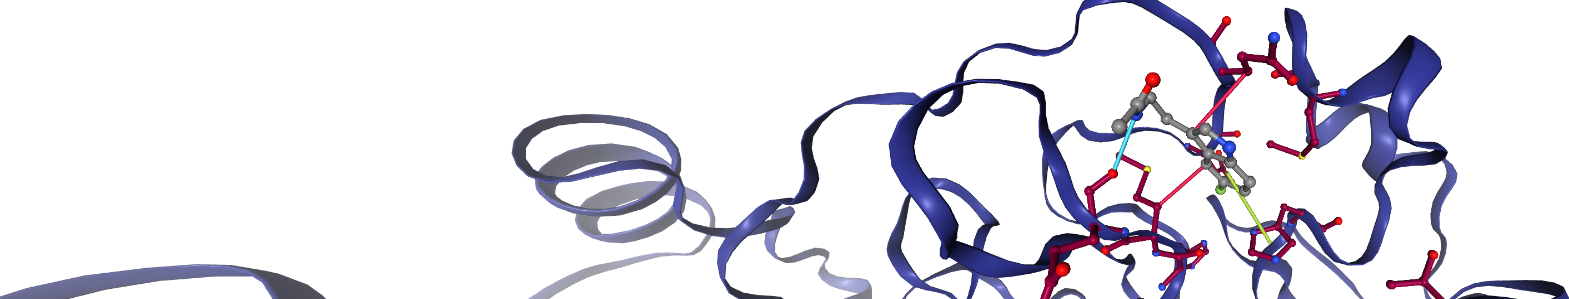

In [58]:
view._display_image()

In [59]:
structures[0].to_dataframes()

### LIG:A:1101

#### Hydrophobic

,RESNR,RESTYPE,RESCHAIN,RESNR_LIG,RESTYPE_LIG,RESCHAIN_LIG,DIST,LIGCARBONIDX,PROTCARBONIDX,LIGCOO,PROTCOO
0,189,GLN,A,1101,LIG,A,3.86,2388,1468,"(12.351, 0.308, 24.296)","(12.914, 2.516, 27.409)"


#### Hbond-Don

,RESNR,RESTYPE,RESCHAIN,RESNR_LIG,RESTYPE_LIG,RESCHAIN_LIG,SIDECHAIN,DIST_H-A,DIST_D-A,DON_ANGLE,PROTISDON,DONORIDX,DONORTYPE,ACCEPTORIDX,ACCEPTORTYPE,LIGCOO,PROTCOO
0,25,THR,A,1101,LIG,A,True,3.27,3.78,114.96,True,178,O3,2393,O2,"(9.21, -5.539, 26.16)","(7.985, -9.003, 27.055)"


#### Pistacking

,RESNR,RESTYPE,RESCHAIN,RESNR_LIG,RESTYPE_LIG,RESCHAIN_LIG,PROT_IDX_LIST,CENTDIST,ANGLE,OFFSET,TYPE,LIG_IDX_LIST,LIGCOO,PROTCOO
0,41,HIS,A,1101,LIG,A,"308,309,310,311,312",4.80,79.18,1.16,T,"2386,2387,2388,2389,2390,2391","(12.037333333333335, -0.7394999999999999, 23.4...","(11.808800000000002, -5.0969999999999995, 21.4..."


[(<BindingSite with name='LIG:A:1101' and 3 interaction types>,
  'hydrophobic',
    RESNR RESTYPE RESCHAIN RESNR_LIG RESTYPE_LIG RESCHAIN_LIG  DIST  \
  0   189     GLN        A      1101         LIG            A  3.86   
  
    LIGCARBONIDX PROTCARBONIDX                   LIGCOO                  PROTCOO  
  0         2388          1468  (12.351, 0.308, 24.296)  (12.914, 2.516, 27.409)  ),
 (<BindingSite with name='LIG:A:1101' and 3 interaction types>,
  'hbond-don',
    RESNR RESTYPE RESCHAIN RESNR_LIG RESTYPE_LIG RESCHAIN_LIG SIDECHAIN  \
  0    25     THR        A      1101         LIG            A      True   
  
    DIST_H-A DIST_D-A DON_ANGLE PROTISDON DONORIDX DONORTYPE ACCEPTORIDX  \
  0     3.27     3.78    114.96      True      178        O3        2393   
  
    ACCEPTORTYPE                 LIGCOO                  PROTCOO  
  0           O2  (9.21, -5.539, 26.16)  (7.985, -9.003, 27.055)  ),
 (<BindingSite with name='LIG:A:1101' and 3 interaction types>,
  'pistacking',
   

In [60]:
structures[0].view()

NGLWidget()

## Generating publication-worthy figures

TBD.

Below is an example of 1) Creating PDB files for each interaction type found by `InteractionFingerprint().calculate_fingerprint()` and 2) Producing images of these using the PyMol API.

Note: The current hard-coded view is based on MPro

In [61]:
# Using the methoxy ligand as an example

from plipify.core import Structure
methoxy = Structure.from_pdbfile(path="./data/Mpro/aligned/Mpro-P0157_0A/Mpro-P0157_0A_bound_chainA.pdb")

Create individual PDB files based on the interaction type, this will produce PDB files with bfactor values per residue representing the number of ligand interactions at that particular site. 

We also set the `summed` flag to `True` to add up all interactions and generate a PDB file containing all interaction types summed together.

In [62]:
from plipify.visualization import fingerprint_writepdb

output_path = Path("./output/")
pdb_ints = fingerprint_writepdb(fingerprint_df=fp, structure=methoxy, output_path=output_path, ligand=True, summed=True)

Analysing hydrophobic interactions...


/home/andrea/.local/miniconda/envs/test/lib/python3.8/site-packages/MDAnalysis/topology/base.py:203: DeprecationWarning:

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

/home/andrea/.local/miniconda/envs/test/lib/python3.8/site-packages/MDAnalysis/core/selection.py:690: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance

Written sys_int_hydrophobic.pdb to output/interaction_pdbs
Analysing hbond-don interactions...
Written sys_int_hbond-don.pdb to output/interaction_pdbs
Analysing hbond-acc interactions...
Written sys_int_hbond-acc.pdb to output/interaction_pdbs
Analysing saltbridge interactions...
Written sys_int_saltbridge.pdb to output/interaction_pdbs
Analysing pistacking interactions...
Written sys_int_pistacking.pdb to output/interaction_pdbs
Analysing pication interactions...
Written sys_int_pication.pdb to output/interaction_pdbs
Analysing halogen interactions...
Written sys_int_halogen.pdb to output/interaction_pdbs
Written sys_summed_interactions.pdb to output/interaction_pdbs


In [63]:
pdb_ints

{'hydrophobic': <Structure with 300 residues, 1 ligands (0 of which were ignored) and 1 characterized binding sites. (loaded from file `output/interaction_pdbs/sys_int_hydrophobic.pdb`)>,
 'hbond-don': <Structure with 300 residues, 1 ligands (0 of which were ignored) and 1 characterized binding sites. (loaded from file `output/interaction_pdbs/sys_int_hbond-don.pdb`)>,
 'hbond-acc': <Structure with 300 residues, 1 ligands (0 of which were ignored) and 1 characterized binding sites. (loaded from file `output/interaction_pdbs/sys_int_hbond-acc.pdb`)>,
 'saltbridge': <Structure with 300 residues, 1 ligands (0 of which were ignored) and 1 characterized binding sites. (loaded from file `output/interaction_pdbs/sys_int_saltbridge.pdb`)>,
 'pistacking': <Structure with 300 residues, 1 ligands (0 of which were ignored) and 1 characterized binding sites. (loaded from file `output/interaction_pdbs/sys_int_pistacking.pdb`)>,
 'pication': <Structure with 300 residues, 1 ligands (0 of which were ig

We will use the `VisPymol` class to make a figure of all interactions summed

In [76]:
from plipify.visualization import VisPymol

spectrum_cols = ["white_green", "white_pink", "white_cyan", "white_red", "white_blue", "white_yellow", "white_orange", "white_purple"]

for i, interaction in enumerate(pdb_ints):

    v = VisPymol(pdb=pdb_ints[interaction]._path)
    v.load()
    v.set_style()
    v.create_image(surface=True, ligand_col="green", spectrum_col=spectrum_cols[i])
    v.render(name=f"{interaction}_pymol_image", save_path="./output/")

Launching PyMol session...
Loading supplied PDB file...
Highlighting ligand interaction sites...
Setting PyMol view...
Rendering PyMol image...
Image created! Saving to output/hydrophobic_pymol_image.png
Launching PyMol session...
Loading supplied PDB file...
Highlighting ligand interaction sites...
Setting PyMol view...
Rendering PyMol image...
Image created! Saving to output/hbond-don_pymol_image.png
Launching PyMol session...
Loading supplied PDB file...
Highlighting ligand interaction sites...
Setting PyMol view...
Rendering PyMol image...
Image created! Saving to output/hbond-acc_pymol_image.png
Launching PyMol session...
Loading supplied PDB file...
Highlighting ligand interaction sites...
Setting PyMol view...
Rendering PyMol image...
Image created! Saving to output/saltbridge_pymol_image.png
Launching PyMol session...
Loading supplied PDB file...
Highlighting ligand interaction sites...
Setting PyMol view...
Rendering PyMol image...
Image created! Saving to output/pistacking_py

Show sample figure

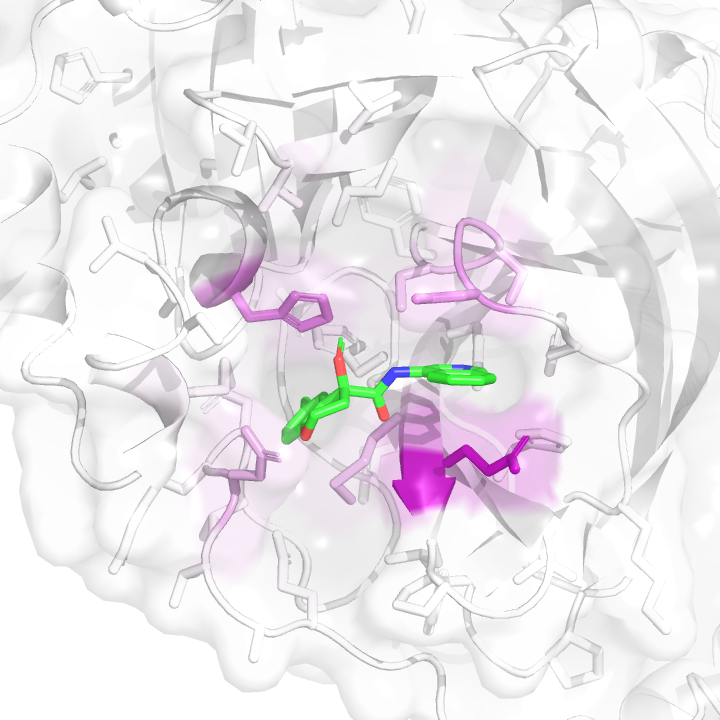

In [79]:
from IPython.display import Image
Image(filename='output/summed_interactions_pymol_image.png') 

We also may want to remove the ligand from the image, this can be done with the `show_ligand` flag: 

In [77]:
for i, interaction in enumerate(pdb_ints):

    v = VisPymol(pdb=pdb_ints[interaction]._path)
    v.load()
    v.set_style()
    v.create_image(surface=True, ligand_col="green", spectrum_col=spectrum_cols[i], show_ligand=False)
    v.render(name=f"{interaction}_pymol_image_no_ligand", save_path="./output/")

Launching PyMol session...
Loading supplied PDB file...
Highlighting ligand interaction sites...
Setting PyMol view...
Rendering PyMol image...
Image created! Saving to output/hydrophobic_pymol_image_no_ligand.png
Launching PyMol session...
Loading supplied PDB file...
Highlighting ligand interaction sites...
Setting PyMol view...
Rendering PyMol image...
Image created! Saving to output/hbond-don_pymol_image_no_ligand.png
Launching PyMol session...
Loading supplied PDB file...
Highlighting ligand interaction sites...
Setting PyMol view...
Rendering PyMol image...
Image created! Saving to output/hbond-acc_pymol_image_no_ligand.png
Launching PyMol session...
Loading supplied PDB file...
Highlighting ligand interaction sites...
Setting PyMol view...
Rendering PyMol image...
Image created! Saving to output/saltbridge_pymol_image_no_ligand.png
Launching PyMol session...
Loading supplied PDB file...
Highlighting ligand interaction sites...
Setting PyMol view...
Rendering PyMol image...
Image

In [80]:
Image(filename='output/output/summed_interactions_pymol_image_no_ligand.png') 

FileNotFoundError: [Errno 2] No such file or directory: 'output/output/summed_interactions_pymol_image_no_ligand.png'

Sometimes when rendering residues as "sticks" they can appear to float above beta sheets. One way to get around this is to ensure beta sheets follow the backbone residues (at a cost of visual aesthetics) e.g.

In [78]:
for i, interaction in enumerate(pdb_ints):

    v = VisPymol(pdb=pdb_ints[interaction]._path)
    v.load()
    v.set_style(flat_sheets=0)
    v.create_image(surface=True, ligand_col="green", spectrum_col=spectrum_cols[i], show_ligand=False)
    v.render(name=f"{interaction}_pymol_image_no_ligand_undulating_sheets", save_path="./output/")

Launching PyMol session...
Loading supplied PDB file...
Highlighting ligand interaction sites...
Setting PyMol view...
Rendering PyMol image...
Image created! Saving to output/hydrophobic_pymol_image_no_ligand_undulating_sheets.png
Launching PyMol session...
Loading supplied PDB file...
Highlighting ligand interaction sites...
Setting PyMol view...
Rendering PyMol image...
Image created! Saving to output/hbond-don_pymol_image_no_ligand_undulating_sheets.png
Launching PyMol session...
Loading supplied PDB file...
Highlighting ligand interaction sites...
Setting PyMol view...
Rendering PyMol image...
Image created! Saving to output/hbond-acc_pymol_image_no_ligand_undulating_sheets.png
Launching PyMol session...
Loading supplied PDB file...
Highlighting ligand interaction sites...
Setting PyMol view...
Rendering PyMol image...
Image created! Saving to output/saltbridge_pymol_image_no_ligand_undulating_sheets.png
Launching PyMol session...
Loading supplied PDB file...
Highlighting ligand i